### **Importing Libraries**

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import random
import math
import torch
import copy
from IPython.display import Image
import tqdm
import pandas as pd
from skimage.color import rgb2lab, lab2rgb, label2rgb

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [17]:
import numpy as np
import math
from skimage import io, color

class SuperPixel:
    def __init__(self, h, w, l, a, b):
        self.h, self.w, self.l, self.a, self.b = h, w, l, a, b
        self.pixels = []
    def update(self, h, w, l, a, b):
        self.h, self.w, self.l, self.a, self.b = h, w, l, a, b

def initialize_clusters(S, img):
    clusters = []
    for h in range(S//2, img.shape[0], S):
        for w in range(S//2, img.shape[1], S):
            l, a, b = img[h, w]
            clusters.append(SuperPixel(h, w, l, a, b))
    return clusters

def gradient(h, w, img):
    h = min(h, img.shape[0] - 2)
    w = min(w, img.shape[1] - 2)
    return np.sum(np.abs(img[h+1, w+1] - img[h, w]))

def refine_clusters(clusters, img):
    for c in clusters:
        min_grad, new_h, new_w = gradient(c.h, c.w, img), c.h, c.w
        for dh, dw in [(-1, -1), (-1, 1), (1, -1), (1, 1)]:
            H, W = c.h + dh, c.w + dw
            if 0 <= H < img.shape[0] and 0 <= W < img.shape[1]:
                grad = gradient(H, W, img)
                if grad < min_grad:
                    min_grad, new_h, new_w = grad, H, W
        c.update(new_h, new_w, *img[new_h, new_w])

def assign_pixels(clusters, S, img, m):
    img_h, img_w = img.shape[:2]
    tag, dis = {}, np.full((img_h, img_w), np.inf)
    for c in clusters:
        for h in range(max(0, c.h - 2 * S), min(img_h, c.h + 2 * S)):
            for w in range(max(0, c.w - 2 * S), min(img_w, c.w + 2 * S)):
                Dc = np.linalg.norm(img[h, w] - [c.l, c.a, c.b])
                Ds = math.sqrt((h - c.h) ** 2 + (w - c.w) ** 2)
                D = math.sqrt((Dc / m) ** 2 + (Ds / S) ** 2)
                if D < dis[h, w]:
                    tag[h, w] = c
                    dis[h, w] = D
    for (h, w), c in tag.items():
        c.pixels.append((h, w))

def update_clusters(clusters, img):
    for c in clusters:
        if c.pixels:
            h_vals, w_vals = zip(*c.pixels)
            c.update(np.mean(h_vals, dtype=int), np.mean(w_vals, dtype=int), *img[np.mean(h_vals, dtype=int), np.mean(w_vals, dtype=int)])

def recolor_image(img, clusters, filename):
    output = np.copy(img)
    for c in clusters:
        for h, w in c.pixels:
            output[h, w] = [c.l, c.a, c.b]
        output[c.h, c.w] = [0, 0, 0]
    io.imsave(filename, (color.lab2rgb(output) * 255).astype(np.uint8))

def slic(img, k=100, m=20, iterations=10):
    img_h, img_w = img.shape[:2]
    S = int(math.sqrt(img_h * img_w / k))
    clusters = initialize_clusters(S, img)
    refine_clusters(clusters, img)
    for _ in range(iterations):
        assign_pixels(clusters, S, img, m)
        update_clusters(clusters, img)
    recolor_image(img, clusters, 'output.png')
    return clusters

# Load image and process
rgb_img = io.imread("./Dataset/frame_0000.jpg")
lab_img = color.rgb2lab(rgb_img)
slic(lab_img)

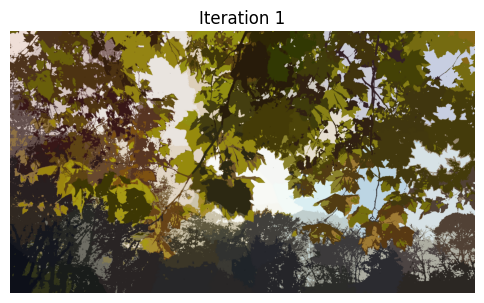

In [ ]:
class SuperPixel:
    def __init__(self, h, w, l, a, b):
        self.h, self.w, self.l, self.a, self.b = h, w, l, a, b
        self.pixels = []

    def update(self, h, w, l, a, b):
        self.h, self.w, self.l, self.a, self.b = h, w, l, a, b

def initialize_clusters_random(k, img):

    clusters = []
    img_h, img_w = img.shape[:2]
    for _ in range(k):
        h, w = random.randint(0, img_h - 1), random.randint(0, img_w - 1)
        l, a, b = img[h, w]
        clusters.append(SuperPixel(h, w, l, a, b))
    return clusters

def assign_pixels(clusters, S, img, m):

    img_h, img_w = img.shape[:2]
    labels = -np.ones((img_h, img_w), dtype=int)
    distances = np.full((img_h, img_w), np.inf)

    for idx, c in enumerate(clusters):
        h_range = range(max(0, c.h - 2 * S), min(img_h, c.h + 2 * S))
        w_range = range(max(0, c.w - 2 * S), min(img_w, c.w + 2 * S))

        for h in h_range:
            for w in w_range:
                Dc = np.linalg.norm(img[h, w] - [c.l, c.a, c.b])
                Ds = math.sqrt((h - c.h) ** 2 + (w - c.w) ** 2)
                D = math.sqrt((Dc / m) ** 2 + (Ds / S) ** 2)

                if D < distances[h, w]:
                    labels[h, w] = idx
                    distances[h, w] = D

    return labels

def update_clusters(clusters, img, labels):

    img_h, img_w = img.shape[:2]
    new_clusters = [SuperPixel(0, 0, 0, 0, 0) for _ in clusters]
    counts = np.zeros(len(clusters), dtype=int)

    for h in range(img_h):
        for w in range(img_w):
            cluster_idx = labels[h, w]
            if cluster_idx != -1:
                c = new_clusters[cluster_idx]
                c.h += h
                c.w += w
                c.l += img[h, w, 0]
                c.a += img[h, w, 1]
                c.b += img[h, w, 2]
                counts[cluster_idx] += 1

    for i, c in enumerate(new_clusters):
        if counts[i] > 0:
            c.update(
                h=c.h // counts[i], w=c.w // counts[i],
                l=c.l // counts[i], a=c.a // counts[i], b=c.b // counts[i]
            )
    return new_clusters

def recolor_image(img, clusters, labels):

    output = np.copy(img)

    for i, c in enumerate(clusters):
        mask = labels == i
        output[mask] = [c.l, c.a, c.b]
        output[c.h, c.w] = [0, 0, 0]

    rgb_output = (lab2rgb(output) * 255).astype(np.uint8)
    return rgb_output


def slic(img, k=100, m=20, iterations=10):

    img_h, img_w = img.shape[:2]
    S = int(math.sqrt(img_h * img_w / k))

    clusters = initialize_clusters_random(k, img)

    for i in range(iterations):

        labels = assign_pixels(clusters, S, img, m)

        clusters = update_clusters(clusters, img, labels)

        output = recolor_image(img, clusters, labels)

        plt.figure(figsize=(6, 6))
        plt.imshow(output)
        plt.title(f"Iteration {i+1}")
        plt.axis("off")
        plt.show()

rgb_img = cv2.imread("./Dataset/frame_0000.jpg")
rgb_img = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2RGB)
lab_img = rgb2lab(rgb_img)

slic(lab_img, k=100, m=20, iterations=10)